# A tour of regression metrics

Author: [Thomas Moreau](https://tommoral.github.io/) and [Alexandre Gramfort](http://alexandre.gramfort.net)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#  Evaluating the model quality


For supervised learning algorithms, where one wants to predict a target $y$ from a given input $X$, one needs to define a loss function. For a model $f_\theta$, parametrized by $\theta$, the goal of supervised learning can be written as
$$
    \min_{\theta \in \Theta} \frac{1}{N}\sum_{i=1}^N \ell(y_i, f_\theta(X_i))]
$$
for a well chosen loss function $\ell$ which measures the discrepancy between the predicted $f_\theta(X)$ and the true target $y$.

To **evaluate the model**, one needs to use a set of unseen data -- called *test set* or *validation set* -- to estimate the generalization performances of the model. This generalization can be quantified by computing the same loss used for training. However, these loss are not always very informative as there value can be hard to interpret (scale, imbalance, $\dots$).

To quantify the performance of a regression model different evaluation metrics are possible. We review below classical metric choices.

The simple way to use a scoring metric during cross-validation is via the scoring parameter of [`sklearn.model_selection.cross_validate`.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).
We will see now different metrics to evaluate the models.

See https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics for more details.

## Regression Metrics


### Mean Squared Error (MSE)

The most classical way to measure distance is to use the the $\ell_2$-norm. The MSE metric simply computes the average $\ell_2$-distance between the prediction and the true target, *i.e.*
$$
    MSE(y, \widehat y) = \frac{1}{N}\sum_{i=1}^N (y_i - \widehat y_i)^2
$$

While this metric can be useful to evaluate linear regression models with gaussian noise, it can fail to distinguish between good and bad cases when the assumptions of the linear model are broken. This is illustrated with the [Anscombe Quartet](https://fr.wikipedia.org/wiki/Quartet_d%27Anscombe), where 4 very different datasets have the same MSE error for linear regression. Note that as the `LinearRegression` fo scikit-learn is an Ordinary Least Squares, the reported MSE is the lowest one that can be achieved for a linear model.


[0.50009091] 3.0000909090909103
[0.5] 3.000909090909089
[0.49972727] 3.002454545454545
[0.49990909] 3.0017272727272726


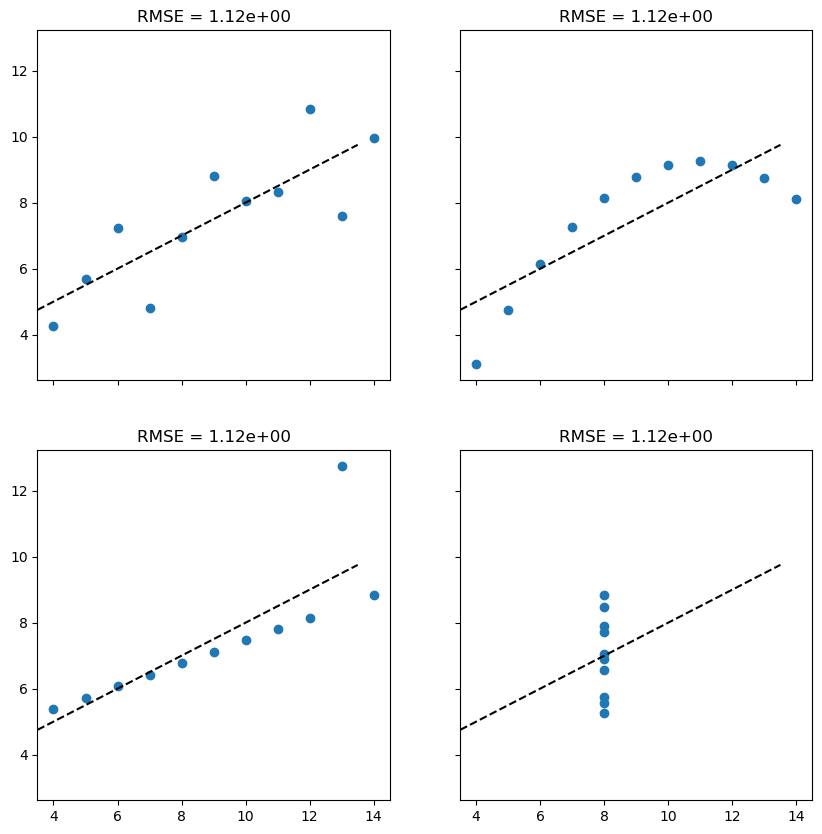

In [ ]:
import json

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import pandas as pd

reg = LinearRegression()

with open("anscombe_quartet.json") as f:
    anscombe_quartet = np.array(json.load(f))

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)

for data, ax in zip(anscombe_quartet, axes.ravel()):
    x, y = data[0], data[1]
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)

    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, "k--")
    ax.set_xlim(xlim)

    ax.set_title(f"RMSE = {np.sqrt(mean_squared_error(y_pred, y)):.2e}")

    df = pd.DataFrame(np.array(data).T)
    print(reg.coef_, reg.intercept_)

In [14]:
import pandas as pd

for i, data in enumerate(anscombe_quartet):
    print(i)
    df = pd.DataFrame(data.T)
    print(df.describe())

0
               0          1
count  11.000000  11.000000
mean    9.000000   7.500909
std     3.316625   2.031568
min     4.000000   4.260000
25%     6.500000   6.315000
50%     9.000000   7.580000
75%    11.500000   8.570000
max    14.000000  10.840000
1
               0          1
count  11.000000  11.000000
mean    9.000000   7.500909
std     3.316625   2.031657
min     4.000000   3.100000
25%     6.500000   6.695000
50%     9.000000   8.140000
75%    11.500000   8.950000
max    14.000000   9.260000
2
               0          1
count  11.000000  11.000000
mean    9.000000   7.500000
std     3.316625   2.030424
min     4.000000   5.390000
25%     6.500000   6.250000
50%     9.000000   7.110000
75%    11.500000   7.980000
max    14.000000  12.740000
3
               0          1
count  11.000000  11.000000
mean    9.000000   7.500909
std     3.316625   2.030579
min     8.000000   5.250000
25%     8.000000   6.170000
50%     8.000000   7.040000
75%     8.000000   8.190000
max    19.00

This metric can also be rescaled to take into account the variance of the original $y$. 

This is called the Explained Variance:
$$
    \text{Var}_{\text{explained}}(y, \widehat y) = \frac{\sum_{i=1}^N (y_i - \widehat y_i)^2
                                         }{\sum_{i=1}^N (y_i - \bar y)^2}
                                   = \frac{\text{MSE}(y, \widehat y)}{\text{Var}(y)}
    \enspace ,
$$
where $\bar y$ is the mean value of $y$. 

This value is also linked to the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) as $R^2 = 1 - \text{Var}_{\text{explained}}$.

In [4]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# The Boston house-price data
data_url = "http://lib.stat.cmu.edu/datasets/boston"
# Clean the file format: remove header, merge the row that spans on 2 lines
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Shuffle the data
data, target = shuffle(data, target, random_state=0)
regressor = RandomForestRegressor(n_estimators=10)

print("R2 score:", cross_val_score(regressor, data, target, cv=5))

R2 score: [0.7046321  0.90324092 0.82117814 0.66797656 0.91208121]


In [5]:
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
raw_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
...,...,...,...,...,...,...,...,...,...,...,...
1007,396.90000,5.64,23.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,0.10959,0.00,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0
1009,393.45000,6.48,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,0.04741,0.00,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0


In [6]:
data.shape

(506, 13)

R2 score is convenient because it has a natural scaling: 1 is
perfect prediction, and 0 is around chance

Now let us see which houses are easier to predict. Feature 3 tells us whether the house is along Charles river or not.

In [ ]:
print(
    "Along Charles River:",
    cross_val_score(
        regressor, data[data[:, 3] == 1], target[data[:, 3] == 1], cv=5
    ),
)
print(
    "Not Along Charles River:",
    cross_val_score(
        regressor, data[data[:, 3] == 0], target[data[:, 3] == 0], cv=5
    ),
)

Along Charles River: [  0.37750551   0.3703775  -12.85338374   0.7170686    0.70851219]
Not Along Charles River: [0.77896401 0.87074651 0.88271053 0.79530792 0.90191517]


Note that despite the name, $R^2$ can be a negative value! See the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) as well.

In [ ]:
print(
    "Along Charles River:",
    cross_val_score(
        regressor,
        data[data[:, 3] == 1],
        target[data[:, 3] == 1],
        cv=5,
        scoring="neg_mean_squared_error",
    ),
)
print(
    "Not Along Charles River:",
    cross_val_score(
        regressor,
        data[data[:, 3] == 0],
        target[data[:, 3] == 0],
        cv=5,
        scoring="neg_mean_squared_error",
    ),
)

Along Charles River: [-102.30535714  -84.04335714  -47.82104286  -49.74912857  -29.6372    ]
Not Along Charles River: [-19.10748105 -10.83902872  -6.73442766 -21.20532553  -8.09474787]


From [this](https://stackoverflow.com/a/72388329) StackOverflow answer:

> When we use the term "loss" it is heavily implied that we want to **minimize** it. However when we talk about "score" it's implied that we want to **maximize** it (e.g. accuracy of a classifier). Therefore, when scoring a regression model, a maximal score would mean a minimal loss, i.e. maximize the negated loss.

### Mean Absolute Error (MAE)

Another popular metric for regression is to use the $\ell_1$-norm to quantify the difference between the predictions and the target *i.e.*
$$
    MAE(y, \widehat y) = \frac{1}{N}\sum_{i=1}^N |y_i - \widehat y_i| \enspace .
$$
This metric is less sensitive to strong errors than the MSE, as it does not square the error:

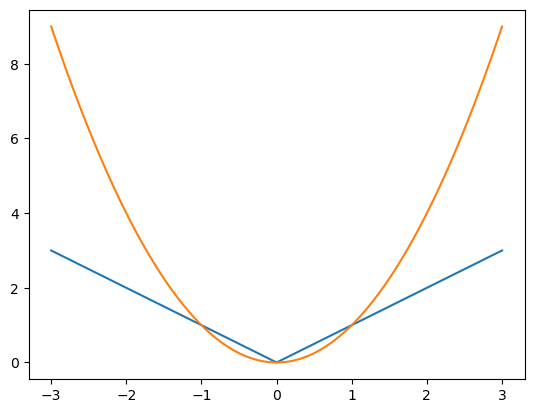

In [ ]:
eps = 1.35
t = np.linspace(-3, 3, 1000)
plt.plot(t, abs(t))
plt.plot(t, t * t)

Let's use this MAE metric on the [Anscombe Quartet](https://fr.wikipedia.org/wiki/Quartet_d%27Anscombe)

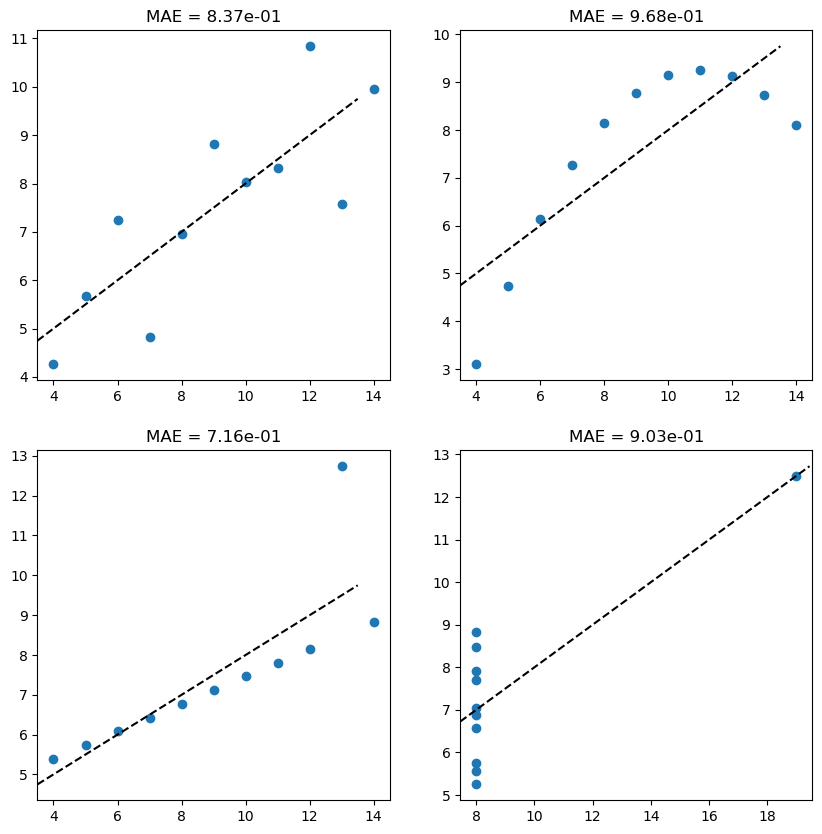

In [ ]:
from sklearn.metrics import mean_absolute_error
import pandas as pd


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for (x, y), ax in zip(anscombe_quartet, axes.ravel()):
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)

    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, "k--")
    ax.set_xlim(xlim)
    ax.set_title(f"MAE = {mean_absolute_error(y_pred, y):.2e}")

In particular, the MAE metric is less sensitive to outliers.

But we're in a rather **strange** situation: the model is trained to minimize one objective function but we evaluate its performance based on another metric!

Let's see if we can find a regressor model that aims to optimize something closer
to the MAE. 

For this we will use the [HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)

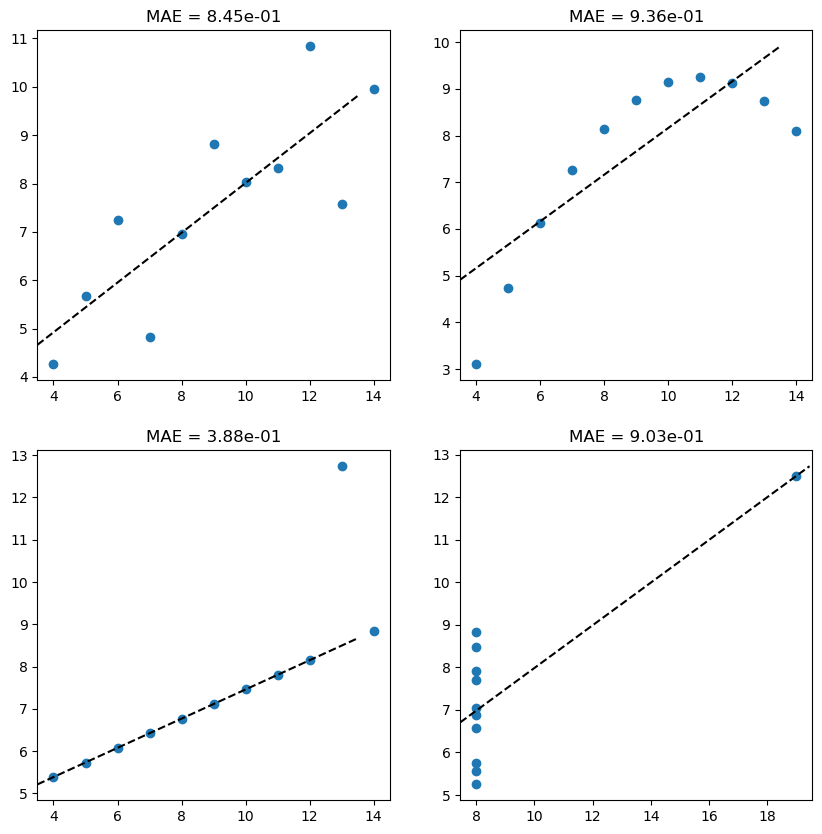

In [ ]:
from sklearn.linear_model import HuberRegressor

reg = HuberRegressor()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for (x, y), ax in zip(anscombe_quartet, axes.ravel()):
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)

    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, "k--")
    ax.set_xlim(xlim)
    ax.set_title(f"MAE = {mean_absolute_error(y_pred, y):.2e}")

Another benefit from this metric is that it permits to report an error in the correct unit, meaningful for an application. 

Taking back the boston dataset:

In [38]:
data, target = shuffle(data, target, random_state=0)

print(
    cross_val_score(
        regressor, data, target, cv=5, scoring="neg_mean_absolute_error"
    )
)

[-2.73568627 -2.2839604  -2.21455446 -3.05772277 -2.1919802 ]


### Scale free metrics

Depending on the application of the regression problem, it might be necessary to use a metric which quantifies the relative error instead of the absolute error. There exists various ways to define such a metric, in particular:

* The Mean Absolute Pourcentage Error (MAPE): $\displaystyle \frac{1}{N}\sum_{i=1}^N \left| \frac{y_i-\widehat y_i}{y_i}\right|~.$ This computes the error between the predicted value and the target, and rescales it compared to the value of the target $y$. This means that the same error of 1 won't have the same effect depending on the fact that $y=1$ or $y=1000$, which can be useful in various situation. It is [available in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) starting from version 0.24.

> [PLCR] Note that the MAPE will punish harder the over-predictions than the under-predictions. For instance, if the estimate is 10x the true value the MAPE is 9 whereas if it is 0.1x the MAPE is 0.9. In other words, the estimator will have a bias towards under-predictions, which might not be desirable. 

> **Question**: How would you train a linear regressor to minimize this score?

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

X, y = data, target
est = LinearRegression()

cv = KFold(n_splits=5, shuffle=True)

print("usual training")
mse_list = []
mape_list = []
for train_idx, test_idx in cv.split(X, y):
    est.fit(X[train_idx], y[train_idx])
    y_true = y[test_idx]
    y_pred = est.predict(X[test_idx])
    mse_list.append(mean_squared_error(y_true, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_true, y_pred))
print("MSE:", np.mean(mse_list))
print("MAPE:", np.mean(mape_list))

print("")

print("weighted training")
mse_list = []
mape_list = []
for train_idx, test_idx in cv.split(X, y):
    est.fit(
        X[train_idx], y[train_idx], sample_weight=1.0 / np.abs(y[train_idx])
    )
    y_true = y[test_idx]
    y_pred = est.predict(X[test_idx])
    mse_list.append(mean_squared_error(y_true, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_true, y_pred))
print("MSE:", np.mean(mse_list))
print("MAPE:", np.mean(mape_list))

usual training
MSE: 23.37294019616826
MAPE: 0.17206446182532306

weighted training
MSE: 26.098175021604344
MAPE: 0.1541133293093139


But what if we had a pipeline?

In [81]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(StandardScaler(), LinearRegression())

print("weighted training")
mse_list = []
mape_list = []
for train_idx, test_idx in cv.split(X, y):
    pipeline.fit(
        X[train_idx], y[train_idx], sample_weight=1.0 / np.abs(y[train_idx])
    )
    y_true = y[test_idx]
    y_pred = est.predict(X[test_idx])
    mse_list.append(mean_squared_error(y_true, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_true, y_pred))
print("MSE:", np.mean(mse_list))
print("MAPE:", np.mean(mape_list))

weighted training


UnsetMetadataPassedError: [sample_weight] are passed but are not explicitly set as requested or not requested for StandardScaler.fit_transform, which is used within Pipeline.fit. Call `StandardScaler.set_fit_request({metadata}=True/False).set_transform_request({metadata}=True/False)` for each metadata you want to request/ignore.

Scikit-learn has recently launched a new feature called **metadata routing** that facilitates the above procedure:

In [82]:
import sklearn

sklearn.set_config(enable_metadata_routing=True)

scaler = StandardScaler().set_fit_request(sample_weight=False)
reg = LinearRegression().set_fit_request(sample_weight=True)

pipeline = make_pipeline(scaler, reg)

print("weighted training")
mse_list = []
mape_list = []
for train_idx, test_idx in cv.split(X, y):
    pipeline.fit(
        X[train_idx], y[train_idx], sample_weight=1.0 / np.abs(y[train_idx])
    )
    y_true = y[test_idx]
    y_pred = est.predict(X[test_idx])
    mse_list.append(mean_squared_error(y_true, y_pred))
    mape_list.append(mean_absolute_percentage_error(y_true, y_pred))
print("MSE:", np.mean(mse_list))
print("MAPE:", np.mean(mape_list))

weighted training
MSE: 24.40557772086467
MAPE: 0.14794643120781859


* The Mean Squared Log Error (MSLE): $\displaystyle \frac{1}{N}\sum_{i=1}^N \Big(\log(1 + y_i) - \log(1 + \widehat y_i)\Big)^2$. This computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss. This metric is best to use when targets have exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric penalizes an under-predicted estimate more than an over-predicted estimate.

> [PLCR] Consider a regression problem where we have to **predict the time taken** by an agent to deliver the food to customers (e.g. Deliveroo). Now, if the regression model which we built overestimates the delivery time, the delivery agent then gets a relaxation on the time he takes to deliver food and this small overestimation is acceptable. But the problem arises when the predicted delivery time is less than the actual trip takes, in this case, the delivery agent is more likely to miss the deadline, as a result, the customer reviews can be affected.

> **Question**: How would you train a linear regressor to minimize this loss?

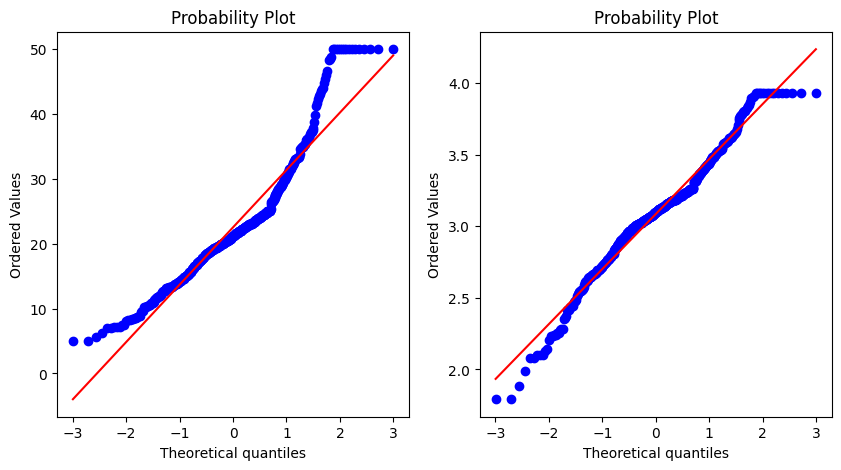

In [79]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
stats.probplot(y, dist="norm", plot=ax[0])
stats.probplot(np.log(1 + y), dist="norm", plot=ax[1])
plt.show()